## Access Mooring Satellite Altimetry Calibration Validation data in Parquet
A jupyter notebook to show how to access and plot the AODN mooring_satellite_altimetry_calibration_validation dataset available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/78d588ed-79dd-47e2-b806-d39025194e7e).

In [1]:
dataset_name = "mooring_satellite_altimetry_calibration_validation"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 230 packages in 25ms


In [3]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata, plot_ts_diagram
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

site_code: string
instrument: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'site_code')
print(list(unique_partition_value))  # showing a subset only

unique_partition_value = query_unique_value(parquet_ds, 'instrument')
print(list(unique_partition_value))  # showing a subset only

['SRSBASJAS', 'SRSSTOJAS', 'SRSBASS3A', 'SRSBASS3B', 'SRSBASSWN', 'SRSBASSWS']
['SBE37', 'ST_CM', 'SBE26', 'Aquad']
CPU times: user 5.18 ms, sys: 62 µs, total: 5.24 ms
Wall time: 4.5 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:449: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:449: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10

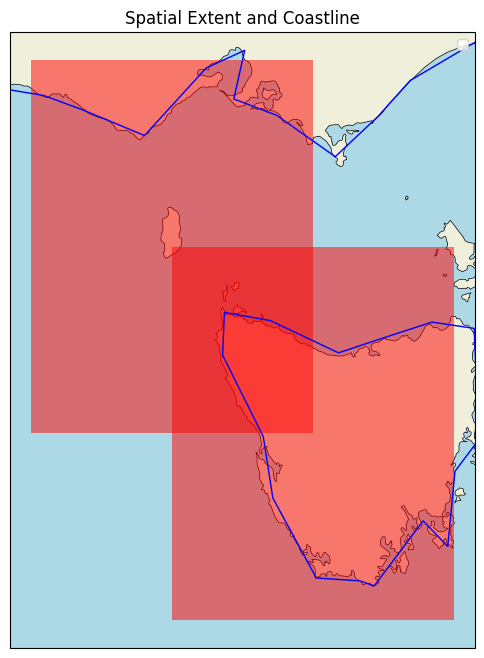

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2001, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site': {'type': 'string'},
 'instrument': {'type': 'string'},
 'instrument_serial_number': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'long_name': 'time',
  'standard_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0,
  'uncertainty': 1.1574074074074073e-05,
  'local_time_zone': '+10'},
 'LONGITUDE': {'type': 'float',
  'long_name': 'longitude',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'uncertainty': 0.0010000000474974513,
  'reference_datum': 'geographical coordinates, WGS84 projection'},
 'LATITUDE': {'type': 'float',
  'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'uncertainty': 0.0010000000474974513,
  'reference_datum': 'geographical coor

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2017-08-01', date_end='2018-06-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-45, lat_max=-28, lon_min=140, lon_max=160)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493275 entries, 0 to 493274
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   filename                  493275 non-null  object        
 1   site                      493275 non-null  object        
 2   instrument_serial_number  493275 non-null  object        
 3   TIME                      493275 non-null  datetime64[ns]
 4   LONGITUDE                 493275 non-null  float32       
 5   LATITUDE                  493275 non-null  float32       
 6   NOMINAL_DEPTH             493275 non-null  float32       
 7   TEMP                      493275 non-null  float32       
 8   TEMP_quality_control      493275 non-null  int32         
 9   UCUR                      4039 non-null    float32       
 10  UCUR_quality_control      4039 non-null    float32       
 11  VCUR                      4039 non-null    float32       
 12  VC

In [13]:
df['NOMINAL_DEPTH'].unique()

array([27.5, 49. , 50. , 17.5, 30. , 41.5, 28. ], dtype=float32)

/tmp/ipykernel_2850849/707641046.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap


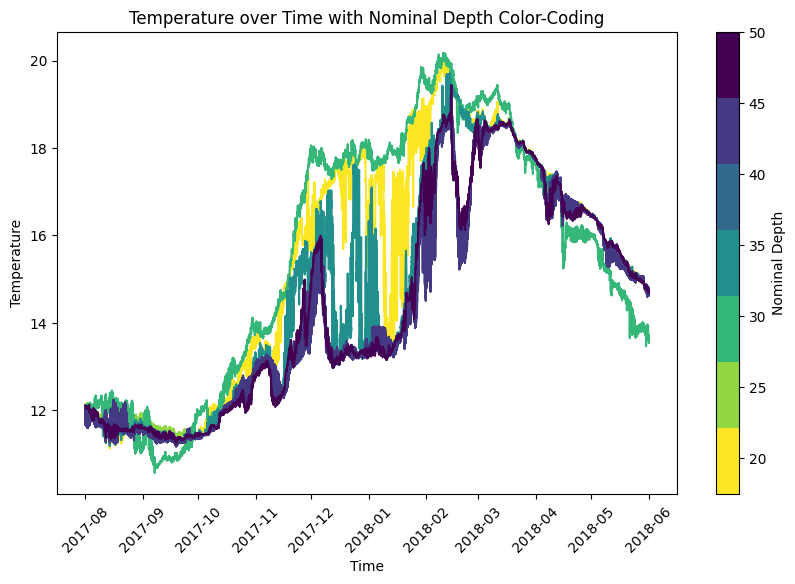

In [14]:
# Create a colormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

unique_depths = sorted(df['NOMINAL_DEPTH'].unique())
cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with color coding
for i, depth in enumerate(unique_depths):
    subset = df[df['NOMINAL_DEPTH'] == depth].sort_values('TIME')  # Sort by TIME
    ax.plot(subset['TIME'], subset['TEMP'], label=f'Depth {depth}', color=cmap(i / len(unique_depths)))

# Create a colorbar
norm = plt.Normalize(vmin=min(unique_depths), vmax=max(unique_depths))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Nominal Depth', orientation='vertical')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature over Time with Nominal Depth Color-Coding')
# Rotate the x-axis time labels to 45 degrees
plt.xticks(rotation=45)

plt.show()


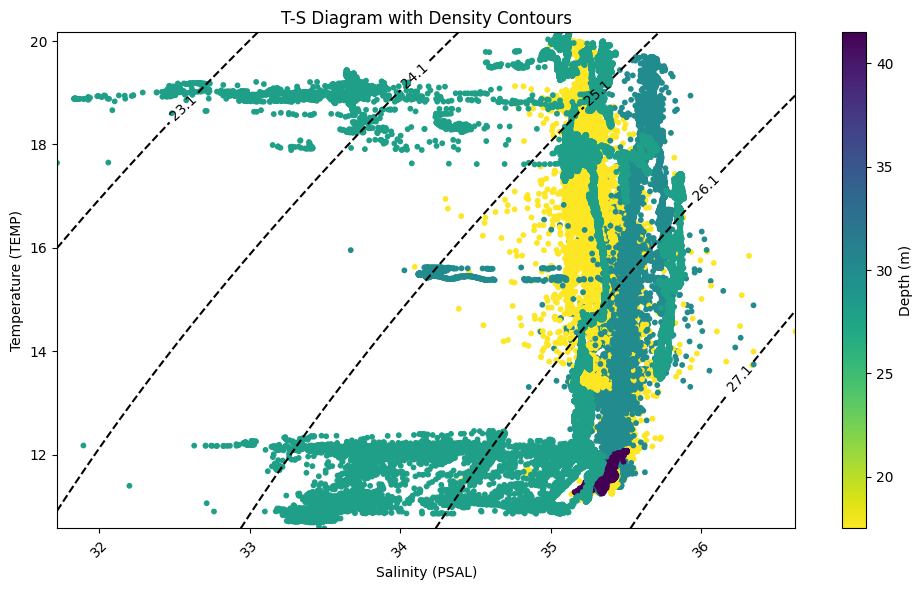

In [15]:
# Filter data where PSAL_quality_control == 1 and PSAL >= 25 (some weird values of 16. to check)
filtered_df = df[(df['PSAL_quality_control'] == 1) & (df['PSAL'] >= 25)]

plot_ts_diagram(filtered_df, temp_col='TEMP', psal_col='PSAL', depth_col='NOMINAL_DEPTH')

## Create a TIME and scalar/number filter

In [16]:
filter_time = create_time_filter(parquet_ds, date_start='2010-07-12', date_end='2012-02-05')

expr_1 = pc.field('site_code') == "SRSBASJAS"
filter = expr_1 & filter_time

In [17]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452574 entries, 0 to 452573
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   filename                  452574 non-null  object        
 1   site                      452574 non-null  object        
 2   instrument_serial_number  452574 non-null  object        
 3   TIME                      452574 non-null  datetime64[ns]
 4   LONGITUDE                 452574 non-null  float32       
 5   LATITUDE                  452574 non-null  float32       
 6   NOMINAL_DEPTH             452574 non-null  float32       
 7   TEMP                      452574 non-null  float32       
 8   TEMP_quality_control      452574 non-null  int32         
 9   UCUR                      0 non-null       float32       
 10  UCUR_quality_control      0 non-null       float32       
 11  VCUR                      0 non-null       float32       
 12  VC